In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
import gc

from sklearn.metrics import roc_auc_score, f1_score
from IPython.display import clear_output

from joblib import load
from tqdm import trange
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import StratifiedKFold

from sparse_vector.sparse_vector import SparseVector

# Data loading

In [2]:
chrom_names = [f'chr{i}' for i in list(range(1, 23)) + ['X', 'Y']]
feature_names = [i[:-4] for i in os.listdir('./data_hg_38/features/sparse/stem_cells') 
                 if i.endswith(".pkl") and not "G-quadruplex" in i]

In [3]:
def chrom_reader(chrom):
    files = sorted([i for i in os.listdir(f'./data_hg_38/dna/') if f"{chrom}_" in i])
    return ''.join([load(f"./data_hg_38/dna/{file}") for file in files])

In [4]:
DNA = {chrom:chrom_reader(chrom) for chrom in tqdm(chrom_names)}
G4 = load('./data_hg_38/targets/sparse/g4.pkl')

DNA_features = {feature: load(f'./data_hg_38/features/sparse/stem_cells/{feature}.pkl')
                for feature in tqdm(feature_names)}

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/321 [00:00<?, ?it/s]

# Dataset class

In [5]:
from torch.utils import data

class Dataset(data.Dataset):
    def __init__(self, chroms, features,
                 dna_source, features_source,
                 labels_source, intervals):
        self.chroms = chroms
        self.features = features
        self.dna_source = dna_source
        self.features_source = features_source
        self.labels_source = labels_source
        self.intervals = intervals
        self.le = LabelBinarizer().fit(np.array([["A"], ["C"], ["T"], ["G"]]))

    def __len__(self):
        return len(self.intervals)

    def __getitem__(self, index):
        interval = self.intervals[index]
        chrom = interval[0]
        begin = int(interval[1])
        end = int(interval[2])
        dna_OHE = self.le.transform(list(self.dna_source[chrom][begin:end].upper()))

        feature_matr = []
        for feature in self.features:
            source = self.features_source[feature]
            if chrom in source:
                feature_matr.append(source[chrom][begin:end])
            else:
                feature_matr.append(np.zeros(end-begin, dtype=np.float32))
        if len(feature_matr) > 0:
            X = np.hstack((dna_OHE, np.array(feature_matr).T/1000)).astype(np.float32)
        else:
            X = dna_OHE.astype(np.float32)
        y = self.labels_source[interval[0]][interval[1]: interval[2]]

        return (X, y)

# Data selection

In [6]:
def get_train_test_data(width):
    np.random.seed(10)
    
    ints_in = []
    ints_out = []

    for chrm in chrom_names:
        for st in range(0, G4[chrm].shape - width, width):
            interval = [st, min(st + width, G4[chrm].shape)]
            if G4[chrm][interval[0]: interval[1]].any():
                ints_in.append([chrm, interval[0], interval[1]])
            else:
                ints_out.append([chrm, interval[0], interval[1]])

    ints_in = np.array(ints_in)
    ints_out = np.array(ints_out)[np.random.choice(range(len(ints_out)), size=len(ints_in) * 3, replace=False)]
    
    np.random.seed(42)
    equalized = np.vstack((ints_in, ints_out))
    equalized = [[inter[0], int(inter[1]), int(inter[2])] for inter in equalized]
    
    train_inds, test_inds = next(StratifiedKFold().split(equalized, [elem[0] for elem in equalized]))
    train_intervals, test_intervals = [equalized[i] for i in train_inds], [equalized[i] for i in test_inds]
    
    np.random.seed(42)
    params = {'batch_size': 32,
              'num_workers':16,
              'shuffle':True}
    
    train_dataset = Dataset(chrom_names, feature_names, 
                           DNA, DNA_features, 
                           G4, train_intervals)
    
    test_dataset = Dataset(chrom_names, feature_names, 
                           DNA, DNA_features, 
                           G4, test_intervals)
    
    loader_train = data.DataLoader(train_dataset, **params)
    loader_test = data.DataLoader(test_dataset, **params)
    
    return loader_train, loader_test

# Train and test

In [7]:
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from IPython.display import clear_output
import time
from copy import deepcopy

In [21]:
def loss_func(output, y_batch):
    return torch.nn.NLLLoss()(torch.transpose(output, 2, 1), y_batch)

def train_epoch(model, optimizer):
    roc_auc_log, precision_log, recall_log, f1_log, acc_log, loss_log = [], [], [], [], [], []
    model.train()
    for X_batch, y_batch in loader_train:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).long()
        optimizer.zero_grad()
        output = model(X_batch)
        if output.dim() == 2:  
            output = output.unsqueeze(0)  
        pred = torch.argmax(output, dim=2)
        with torch.no_grad():
            y_pred = nn.Softmax(dim=1)(output)[:, :,1].cpu().numpy().flatten()
            if np.std(y_batch.cpu().numpy().flatten()) == 0:
                roc_auc = 0
                precision = 0
                recall = 0
            else:
                roc_auc = roc_auc_score(y_batch.cpu().numpy().flatten(),
                                        y_pred)

                precision = precision_score(y_batch.cpu().numpy().flatten(), pred.cpu().numpy().flatten(), zero_division=0)
                recall = recall_score(y_batch.cpu().numpy().flatten(), pred.cpu().numpy().flatten())
                
            precision_log.append(precision)
            recall_log.append(recall)             
            f1_log.append(f1_score(y_batch.cpu().numpy().flatten(),
                             pred.cpu().numpy().flatten(), zero_division=0))

        roc_auc_log.append(roc_auc)
        acc = torch.mean((pred.to(device) == y_batch).float())
        acc_log.append(acc.cpu().numpy())
        loss = loss_func(output, y_batch)
        loss.backward()
        optimizer.step()
        
        loss = loss.item()
        loss_log.append(loss)
        torch.cuda.empty_cache()
    return roc_auc_log, precision_log, recall_log, f1_log, acc_log, loss_log

def test(model):
    np.random.seed(42)
    roc_auc_log, precision_log, recall_log, f1_log, acc_log, loss_log = [], [], [], [], [], []
    model.eval()
    means = []
    with torch.no_grad():
        for X_batch, y_batch in loader_test:
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).long()
            output = model(X_batch)

            if output.dim() == 2:  
                output = output.unsqueeze(0)  
            means.append(y_batch.sum().cpu() / (1.0 * y_batch.shape[0]))
            pred = torch.argmax(output, dim=2)
            if np.std(y_batch.cpu().numpy().flatten()) == 0:
                roc_auc = 0
                precision = 0
                recall = 0
            else:
                roc_auc = roc_auc_score(y_batch.cpu().numpy().flatten(),
                                        nn.Softmax(dim=1)(output)[:, :,1].detach().cpu().numpy().flatten())
                precision = precision_score(y_batch.cpu().numpy().flatten(), pred.cpu().numpy().flatten(), zero_division=0)
                recall = recall_score(y_batch.cpu().numpy().flatten(), pred.cpu().numpy().flatten())

            f1 = f1_score(y_batch.cpu().numpy().flatten(),
                                      pred.cpu().numpy().flatten(), zero_division=0)
            if f1 == 0.0 and torch.all(y_batch == 0) and torch.all(pred == 0):
                pass
            else:
                f1_log.append(f1)
            roc_auc_log.append(roc_auc)
            precision_log.append(precision)
            recall_log.append(recall)     
            acc = torch.mean((pred.to(device) == y_batch).float())
            acc_log.append(acc.cpu().numpy())
            loss = loss_func(output, y_batch)
            loss_log.append(loss.item())
            torch.cuda.empty_cache()
    return roc_auc_log, precision_log, recall_log, f1_log, acc_log, loss_log

def plot_history(train_history, valid_history, title, BatchSize, epoch_to_show=20):
    plt.figure(figsize=(epoch_to_show, 4))
    plt.title(title)    
    
    epoch_num = len(valid_history)
    train_history = np.array([None] * (BatchSize * epoch_to_show) + train_history)
    valid_history = np.array([None] * epoch_to_show + valid_history)
    
    plt.plot(np.linspace(epoch_num-epoch_to_show+1, epoch_num+1, (epoch_to_show+1)*BatchSize), 
             train_history[-(epoch_to_show+1)*BatchSize:], c='red', label='train')
    plt.plot(np.linspace(epoch_num-epoch_to_show+1, epoch_num+1, epoch_to_show+1),
                valid_history[-epoch_to_show-1:], c='green', label='test')
    
    plt.ylim((0, 1))
    plt.yticks(np.linspace(0, 1, 11))
    plt.xticks(np.arange(epoch_num-epoch_to_show+1, epoch_num+2), 
              np.arange(epoch_num-epoch_to_show, epoch_num+1).astype(int))
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
def train(model, opt, n_epochs, scheduler=None):
    for epoch in range(n_epochs):
        start_time = time.time()
        print("Epoch {} of {}".format(epoch + 1, n_epochs))
        train_auc, train_pr, train_rec, train_f1, train_acc, train_loss = train_epoch(model, opt)
        val_auc, val_pr, val_rec, val_f1, val_acc, val_loss = test(model)
        
        best_models.append(deepcopy(model))
        
        end_time = time.time()
        times.append(end_time - start_time)
        BatchSize = len(train_loss)
        
        train_auc_log.extend(train_auc)
        train_pr_log.extend(train_pr)
        train_rec_log.extend(train_rec)
        train_f1_log.extend(train_f1)
        train_acc_log.extend(train_acc)
        train_loss_log.extend(train_loss)

        val_auc_log.append(np.mean(val_auc))
        val_pr_log.append(np.mean(val_pr))
        val_rec_log.append(np.mean(val_rec))
        val_f1_log.append(np.mean(val_f1))
        val_acc_log.append(np.mean(val_acc))
        val_loss_log.append(np.mean(val_loss))
        
        clear_output()
        plot_history(train_loss_log,     val_loss_log,     'Loss',     BatchSize, epoch_to_show=n_epochs)    
        plot_history(train_acc_log, val_acc_log, 'Accuracy', BatchSize, epoch_to_show=n_epochs)
        plot_history(train_auc_log, val_auc_log, 'Auc',      BatchSize, epoch_to_show=n_epochs)
        plot_history(train_f1_log, val_f1_log,   'F1',       BatchSize, epoch_to_show=n_epochs)
        print("Time: ", end_time/60)
        print("Epoch {}: ROC-AUC = {:.2%}".format(epoch+1, val_auc_log[-1]))
        print("Epoch {}: Precision = {:.3}".format(epoch+1, val_pr_log[-1]))
        print("Epoch {}: Recall = {:.3}".format(epoch+1, val_rec_log[-1]))
        print("Epoch {}: F1-score = {:.3}".format(epoch+1, val_f1_log[-1]))
           
    print("Final ROC-AUC = {:.4}%".format(val_auc_log[-1]*100))
    print("Final Precision = {:.3}".format(val_pr_log[-1]))
    print("Final Recall = {:.3}".format(val_rec_log[-1]))
    print("Final F1-score = {:.3}".format(val_f1_log[-1]))
    
def train_optuna(trial, model, opt, n_epochs):
    best_f1 = 0
    for epoch in range(n_epochs):
        train_auc, train_pr, train_rec, train_f1, train_acc, train_loss = train_epoch(model, opt)
        val_auc, val_pr, val_rec, val_f1, val_acc, val_loss = test(model)
        
        cur_f1 = np.mean(val_f1)
        best_f1 = max(best_f1, cur_f1)
        print("Epoch {}: F1-score = {:.3}".format(epoch+1, cur_f1))
        trial.report(best_f1, epoch)
        if trial.should_prune() or best_f1 < 0.4:
            raise optuna.exceptions.TrialPruned()

    return best_f1

In [9]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Add logging + prepare datasets

In [10]:
import sys
import logging

nblog = open("./logs/cnn_g4_optuna.log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


In [11]:
width = 100
loader_train, loader_test = get_train_test_data(width)

# Baseline

In [12]:
class DeepCNN_12_layers(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.GroupNorm(2, 4),


            nn.Conv2d(4, 8, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.GroupNorm(4, 8),
 

            nn.Conv2d(8, 16, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.GroupNorm(8, 16),


            nn.Conv2d(16, 32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.GroupNorm(16, 32),


            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.GroupNorm(16, 64), 

            nn.Conv2d(64, 128, kernel_size=(5, 5), padding=2),
            nn.ReLU(),
            nn.GroupNorm(32, 128),  


            nn.Conv2d(128, 64, kernel_size=(3, 3), padding=1),  
            nn.ReLU(),
            nn.GroupNorm(32, 64),  


            
            nn.Conv2d(64, 32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.GroupNorm(16, 32),  


            nn.Conv2d(32, 16, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.GroupNorm(8, 16), 


            nn.Conv2d(16, 8, kernel_size=(3, 3), padding=1),  
            nn.ReLU(),
            nn.GroupNorm(4, 8),  


            nn.Conv2d(8, 4, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.GroupNorm(4, 4),  


            nn.Conv2d(4, 1, kernel_size=(3, 3), padding=1),  
            nn.ReLU(),
            nn.GroupNorm(1, 1), 


            
            nn.AlphaDropout(p = 0.2),
            nn.Linear(len(feature_names) + 4, 500),
            nn.AlphaDropout(p = 0.2),
            nn.SELU(),
            nn.Linear(500, 2)
    )

    def forward(self, x):
        batch = x.shape[0]
        x = x.reshape(batch, 1, width, len(feature_names) + 4)
        x = self.seq(x)
        x = torch.squeeze(x)
        x = F.log_softmax(x, dim=-1)
        return x

In [15]:
set_random_seed(42)
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with torch.cuda.device(device):
    model = DeepCNN_12_layers()
    model = nn.DataParallel(model)
    model = model.to(device)
opt = torch.optim.RMSprop(model.parameters(), lr=10**-4, weight_decay=10**-4)

gc.collect()

34

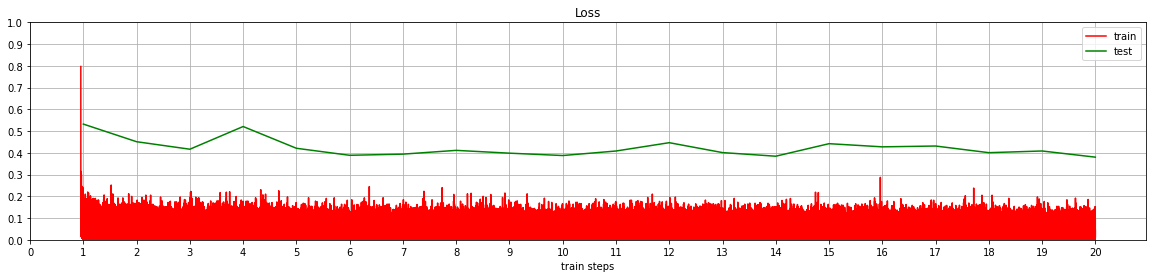

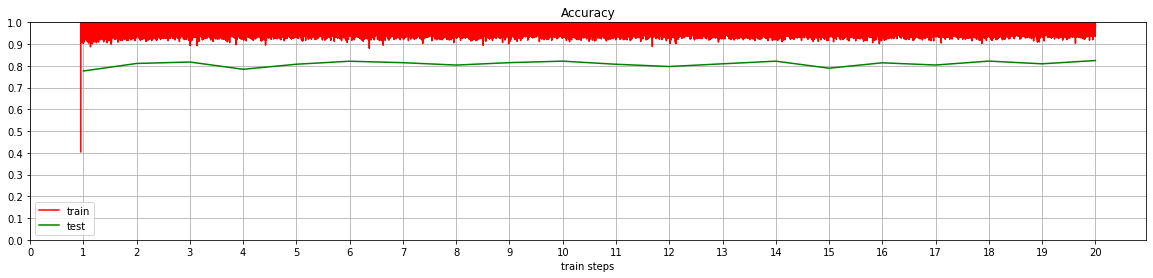

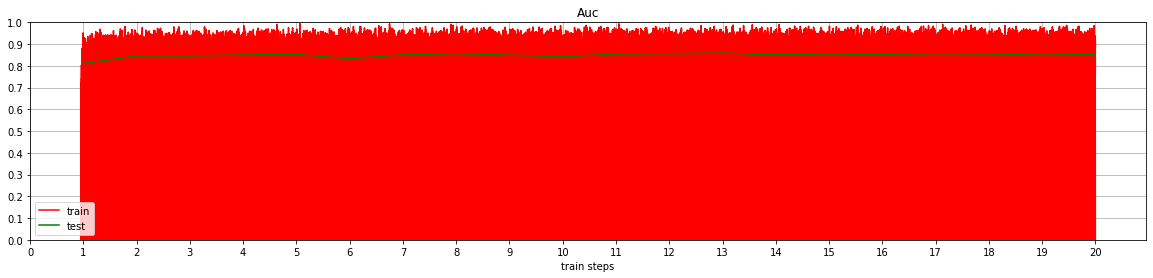

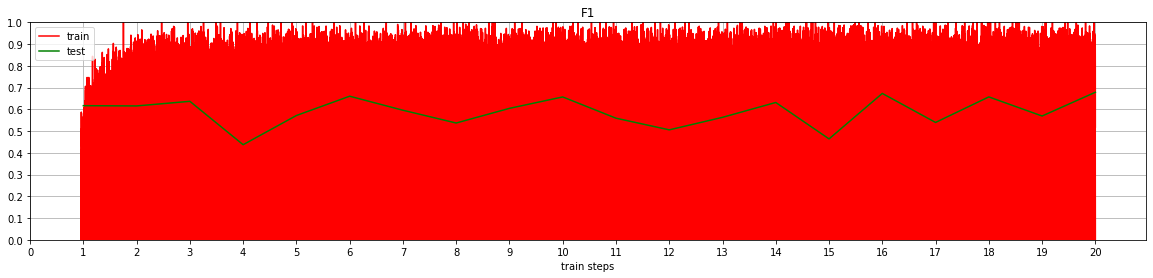

Time:  29104278.46463835
Epoch 20: ROC-AUC = 85.10%
Epoch 20: Precision = 0.709
Epoch 20: Recall = 0.653
Epoch 20: F1-score = 0.679
Final ROC-AUC = 85.1%
Final Precision = 0.709
Final Recall = 0.653
Final F1-score = 0.679


In [52]:
train_auc_log, train_pr_log, train_rec_log, train_f1_log, train_acc_log, train_loss_log = [], [], [], [], [], []
val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log = [], [], [], [], [], []
times = []
best_models = []

train(model, opt, 20)

In [53]:
print("Epoch {}".format(np.argmax(val_f1_log)))
print("Max F1-score: {:.4f}%".format(val_f1_log[np.argmax(val_f1_log)]*100))
print("ROC-AUC: {:.4f}%".format(val_auc_log[np.argmax(val_f1_log)]*100))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 19
Max F1-score: 67.8567%
ROC-AUC: 85.0995%
Precision: 0.7093
Recall: 0.6531
Mean time for 1 epoch 32.84 minutes


In [54]:
torch.save(best_models[np.argmax(val_f1_log)].state_dict(), './models/g4_baseline.pt')

# Optuning model class

In [18]:
def suggest_activation(trial):
    activation_name = trial.suggest_categorical("activation_layer", ["ReLU", "LeakyReLU", "PReLU", "ELU", "SELU"])
    activation_map = {
        "ReLU": nn.ReLU(),
        "LeakyReLU": nn.LeakyReLU(),
        "PReLU": nn.PReLU(),
        "ELU": nn.ELU(),
        "SELU": nn.SELU(),
    }
    return activation_map[activation_name]

class DeepCNN_OptunaTuned(nn.Module):
    def __init__(self, trial, width):
        super().__init__()
        self.width = width
        self.conv_layers = self._build_conv(trial)
        self.flattened_size = self._get_flattened_size()
        self.fc_layers = self._build_fc(trial)

    def _build_conv(self, trial):
        n_layers = trial.suggest_int("n_layers", 2, 16, step=2)
        layers = []
        
        kernel_size = trial.suggest_categorical("kernel_size", [3, 5, 7])
        activation_layer = suggest_activation(trial)
        
        in_channels = 1
        for i in range(n_layers):
            out_channels_multiplier = trial.suggest_categorical(f"out_channels_multiplier_{i}", [2, 4, 8])
            if i < n_layers // 2:
                out_channels = min(512, in_channels * out_channels_multiplier)
            elif i == n_layers - 1 or in_channels // out_channels_multiplier == 0:
                out_channels = 1
            else:
                out_channels = in_channels // out_channels_multiplier
            
            stride = trial.suggest_categorical(f"stride_{i}", [1, 2])
            dilation = trial.suggest_categorical(f"dilation_{i}", [1, 2, 3])
            padding = (kernel_size - 1) * dilation // 2
            
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, dilation=dilation, padding=padding))
            
            num_groups = trial.suggest_categorical(f"num_groups_{i}", [1, 2, 4, 8, 16, 32])
            layers.append(nn.GroupNorm(min(num_groups, out_channels), out_channels))
            
            layers.append(activation_layer)
            
            in_channels = out_channels
            
        return nn.Sequential(*layers)

    def _get_flattened_size(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, self.width, len(feature_names) + 4)
            dummy_output = self.conv_layers(dummy_input)
            return dummy_output.shape[2] * dummy_output.shape[3]
        
    def _build_fc(self, trial):
        linear_size = trial.suggest_int("linear_size", self.width * 4, self.width * 40, log=True)
        return nn.Sequential(
            nn.AlphaDropout(p=trial.suggest_float("dropout_before_linear", 0.15, 0.75, step=0.05)),
            nn.Flatten(-2, -1),
            nn.Linear(self.flattened_size, linear_size),
            nn.AlphaDropout(p=trial.suggest_float("dropout_after_linear", 0.15, 0.75, step=0.05)),
            suggest_activation(trial),
            nn.Linear(linear_size, self.width * 2),
            nn.Unflatten(-1, (self.width, 2)),
        )
       

    def forward(self, x):
        batch = x.shape[0]
        x = x.reshape(batch, 1, self.width, len(feature_names) + 4)
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        x = torch.squeeze(x)
        return F.log_softmax(x, dim=-1)


# Optuning parameters

In [24]:
from torch import optim

def objective(trial):
    width = 100
    loader_train, loader_test = get_train_test_data(width)

    set_random_seed(42)
    torch.cuda.empty_cache()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    #with torch.cuda.device(device):
    model = DeepCNN_OptunaTuned(trial, width)
    model = nn.DataParallel(model)
    model = model.to(device)

    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD", "AdamW"])
    lr = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)

    if optimizer_name == "Adam":
        opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == "RMSprop":
        opt = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == "SGD":
        momentum = trial.suggest_float("momentum", 0.5, 0.99)
        opt = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)
    elif optimizer_name == "AdamW":
        opt = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    try:
        f1 = train_optuna(trial, model, opt, 4)
    except optuna.exceptions.TrialPruned:
        return 0

    return f1

In [ ]:
optuna.logging.get_logger("optuna").addHandler(logging.FileHandler("./logs/cnn_g4_optuna.log"))

study = optuna.create_study(
    study_name="my_study",
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=0),
    storage="sqlite:///optuna_study.db",
    load_if_exists=True,
)

study.optimize(objective, gc_after_trial=True)

[I 2025-04-05 11:58:52,503] Using an existing study with name 'my_study' instead of creating a new one.


Using an existing study with name 'my_study' instead of creating a new one.
Using an existing study with name 'my_study' instead of creating a new one.
